Data Preprocessing

In [77]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
url = 'https://p19-bot-sign-sg.ciciai.com/tos-alisg-i-b2l6bve69y-sg/ca602a4dd2e04e6ea717f6548ca51fa6.csv~tplv-b2l6bve69y-image.image?rk3s=68e6b6b5&x-expires=1719744177&x-signature=sdxk9fyq5FsGMaG9rN5e5sU%2FFhk%3D'
data = pd.read_csv(url)

# Handling Missing Values
data.fillna(data.mean(), inplace=True)

# Encoding Categorical Variables
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])

# Normalizing Numerical Features
numerical_cols = data.columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

Sampling

In [78]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = data.drop(columns=['Diabetes'])  # Change target variable to 'Diabetes'
y = data['Diabetes']

# Ensure target values are either 0 or 1
y = y.apply(lambda x: 1 if x > 0 else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



***LOGISTIC REGRESSION***

In [79]:
# Convert data to PyTorch tensors
import torch

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

Build the model (logistic regresion)

In [80]:
import torch.nn as nn

# Define the Logistic Regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Initialize the model
input_dim = X_train.shape[1]
lr_model = LogisticRegressionModel(input_dim)

Model Training

In [81]:
import torch.optim as optim

# Initialize the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(lr_model.parameters(), lr=0.01)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    lr_model.train()
    optimizer.zero_grad()
    outputs = lr_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Save the model
torch.save(lr_model.state_dict(), 'logistic_regression_model.pth')

Epoch [10/100], Loss: 0.7427
Epoch [20/100], Loss: 0.7192
Epoch [30/100], Loss: 0.6986
Epoch [40/100], Loss: 0.6806
Epoch [50/100], Loss: 0.6648
Epoch [60/100], Loss: 0.6510
Epoch [70/100], Loss: 0.6389
Epoch [80/100], Loss: 0.6282
Epoch [90/100], Loss: 0.6187
Epoch [100/100], Loss: 0.6103


model evaluation

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Evaluating the model
lr_model.eval()
with torch.no_grad():
    lr_predicted = lr_model(X_test_tensor).round()
    lr_y_test_numpy = y_test_tensor.numpy()
    lr_predicted_numpy = lr_predicted.numpy()
    lr_y_prob = lr_model(X_test_tensor).numpy()

    # Calculate accuracy
    lr_accuracy = accuracy_score(lr_y_test_numpy, lr_predicted_numpy)
    
    # Calculate precision
    lr_precision = precision_score(lr_y_test_numpy, lr_predicted_numpy)
    
    # Calculate sensitivity (recall)
    lr_recall = recall_score(lr_y_test_numpy, lr_predicted_numpy)
    
    # Calculate F1 score
    lr_f1 = f1_score(lr_y_test_numpy, lr_predicted_numpy)
    
    # Calculate confusion matrix
    lr_tn, lr_fp, lr_fn, lr_tp = confusion_matrix(lr_y_test_numpy, lr_predicted_numpy).ravel()

    # Calculate ROC AUC
    lr_roc_auc = roc_auc_score(y_test, lr_y_prob)
    
    # Print the results
    print(f'Accuracy: {lr_accuracy:.4f}')
    print(f'Precision: {lr_precision:.4f}')
    print(f'Sensitivity (Recall): {lr_recall:.4f}')
    print(f'F1 Score: {lr_f1:.4f}')
    print(f'Confusion Matrix: TP={lr_tp}, TN={lr_tn}, FP={lr_fp}, FN={lr_fn}')
    print(f'ROC AUC: {lr_roc_auc:.4f}')

Accuracy: 0.6846
Precision: 0.6916
Sensitivity (Recall): 0.6632
F1 Score: 0.6771
Confusion Matrix: TP=4675, TN=5005, FP=2085, FN=2374
ROC AUC: 0.7542


***SVM MODEL***

Model Building

In [83]:
from sklearn.svm import SVC

# Define the SVM model
svm_model = SVC(kernel='linear', probability=True)

Model Training

In [84]:
# Train the model
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_prob = svm_model.predict_proba(X_test)[:, 1]

# Save the model
import joblib
svm_model_path = 'svm_model.pkl'

Model Evalutaion

In [85]:
import pandas as pd

# Predict the test set results
svm_y_pred = svm_model.predict(X_test)
svm_y_prob = svm_model.decision_function(X_test)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_y_pred)

# Calculate precision
svm_precision = precision_score(y_test, svm_y_pred)

# Calculate sensitivity (recall)
svm_recall = recall_score(y_test, svm_y_pred)

# Calculate F1 score
svm_f1 = f1_score(y_test, svm_y_pred)

# Calculate confusion matrix
svm_tn, svm_fp, svm_fn, svm_tp = confusion_matrix(y_test, svm_y_pred).ravel()

# Calculate ROC AUC
svm_roc_auc = roc_auc_score(y_test, svm_y_prob)

# Print the results
print(f'Accuracy: {svm_accuracy:.4f}')
print(f'Precision: {svm_precision:.4f}')
print(f'Sensitivity (Recall): {svm_recall:.4f}')
print(f'F1 Score: {svm_f1:.4f}')
print(f'Confusion Matrix: TP={svm_tp}, TN={svm_tn}, FP={svm_fp}, FN={svm_fn}')
print(f'ROC AUC: {svm_roc_auc:.4f}')

Accuracy: 0.7464
Precision: 0.7247
Sensitivity (Recall): 0.7925
F1 Score: 0.7571
Confusion Matrix: TP=5586, TN=4968, FP=2122, FN=1463
ROC AUC: 0.8228


***compare 2 model***

Cross validation

In [ ]:
#perform cross validation
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross validation
lr_cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring='accuracy')
svm_cv_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')

# Print the cross validation scores
print('Logistic Regression CV Scores:', lr_cv_scores)
print('SVM CV Scores:', svm_cv_scores)

Confidence intervals

In [128]:
# Confidence Intervals
from scipy.stats import sem
import numpy as np

logistic_metrics = [lr_accuracy, lr_precision, lr_recall, lr_f1, lr_roc_auc, lr_tn, lr_fp, lr_fn, lr_tp]
svm_metrics = [svm_accuracy, svm_precision, svm_recall, svm_f1, svm_roc_auc, svm_tn, svm_fp, svm_fn, svm_tp]

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = sem(data)
    margin_of_error = se * 1.96  # For 95% confidence interval
    return mean, margin_of_error

logistic_ci = {metric: confidence_interval([logistic_metrics[i]]) for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])}
svm_ci = {metric: confidence_interval([svm_metrics[i]]) for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])}

print('Logistic Regression Confidence Intervals:')
print(logistic_ci)
print('SVM Confidence Intervals:')
print(svm_ci)

NameError: name 'np' is not defined

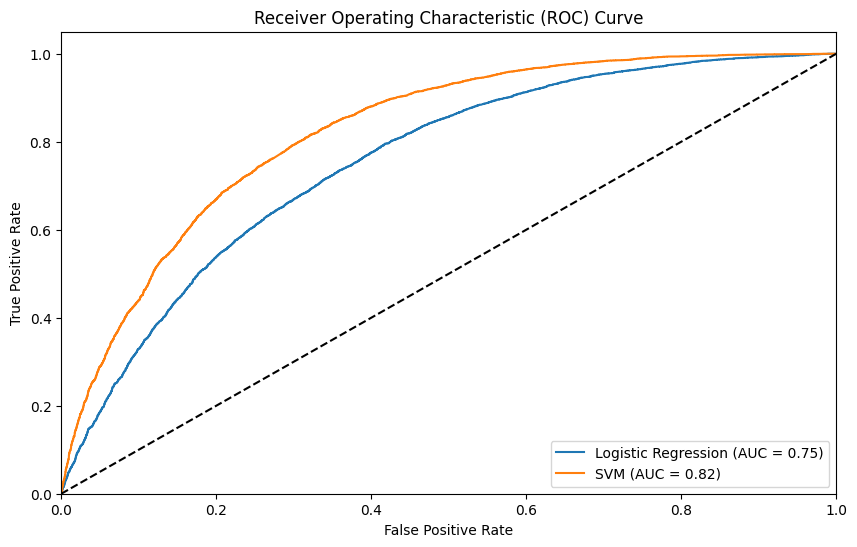

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

lr_prob = lr_model(X_test_tensor).detach().numpy().flatten()



logistic_fpr, logistic_tpr, _ = roc_curve(y_test, lr_prob)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_metrics[4]:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_metrics[4]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Performnce Comparison Table

In [126]:
import pandas as pd

# Assuming logistic_metrics, logistic_ci, svm_metrics, svm_ci are predefined


# Creating the DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Sensitivity (Recall)', 'F1 Score', 'ROC AUC', 'True Positive (TP)', 'True Negative (TN)', 'False Positive (FP)', 'False Negative (FN)'],
    'Logistic Regression': logistic_metrics,
    'Logistic Regression CI': [logistic_ci[metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']] + [None]*4,
    'SVM': svm_metrics,
    'SVM CI': [svm_ci[metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]  + [None]*4
})

# Set the Metric column as the index for better readability
comparison_df.set_index('Metric', inplace=True)

# Display the DataFrame
print(comparison_df.to_markdown())



| Metric               |   Logistic Regression | Logistic Regression CI         |         SVM | SVM CI                         |
|:---------------------|----------------------:|:-------------------------------|------------:|:-------------------------------|
| Accuracy             |              0.684631 | (0.6846311620340901, nan, nan) |    0.746446 | (0.7464460004243582, nan, nan) |
| Precision            |              0.691568 | (0.6915680473372781, nan, nan) |    0.724702 | (0.7247016087182149, nan, nan) |
| Sensitivity (Recall) |              0.663215 | (0.6632146403745212, nan, nan) |    0.792453 | (0.7924528301886793, nan, nan) |
| F1 Score             |              0.677095 | (0.6770946484176986, nan, nan) |    0.757064 | (0.7570644439926815, nan, nan) |
| ROC AUC              |              0.754203 | (0.7542031489827103, nan, nan) |    0.822764 | (0.8227643049129596, nan, nan) |
| True Positive (TP)   |           5005        |                                | 4968        |  